<a href="https://colab.research.google.com/github/mohdtanweer/ToxicCommentClassification/blob/master/toxic_comment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Let's mount the google drive first

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install nltk

In [3]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> l

Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [ ] cess_esp............ CESS-ESP Treebank
  [ ] chat80.....

True

In [0]:
import re
import tensorflow as tf
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook

from nltk.corpus import stopwords

In [5]:
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

Using TensorFlow backend.


In [6]:
import os
os.listdir('/content/gdrive/My Drive')

['Hcl Route Map.docx',
 'Data_Sets',
 'Colab Notebooks',
 'GANs',
 'RR',
 'ResNet50',
 'TensorFlowSpecialisation',
 'CoronaWhy',
 'BERT',
 'glove',
 'ToxicCommentClassification']

In [0]:
base_dir = '/content/gdrive/My Drive/'

In [0]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = f"{base_dir}/glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [0]:
train = pd.read_csv(f'{base_dir}/ToxicCommentClassification/data/train.csv')

In [10]:
train.shape

(159571, 8)

In [11]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [0]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

In [13]:
y.shape

(159571, 6)

In [0]:
comments_train = train['comment_text']
comments_train = list(comments_train)

In [15]:
len(comments_train)

159571

In [0]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

In [17]:
texts = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    texts.append(clean_text(line))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
print('Sample data:', texts[1], y[1])

Sample data: aww matches background colour im seemingly stuck thanks talk 2151 january 11 2016  [0 0 0 0 0 0]


In [19]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 324669


In [20]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [22]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12255  1269  6813   382  6334  1132]
validation:  [3039  326 1636   96 1543  273]


In [23]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 3556 16419     8   115   873 16419 35424    42 11481  1798   565  5495
   561  1966     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [24]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/gdrive/My Drive//glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [0]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

In [0]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

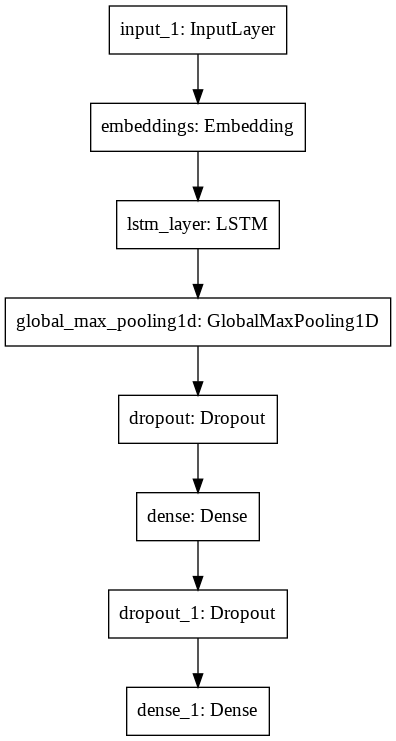

In [27]:
tf.keras.utils.plot_model(model)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          32467000  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [29]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/10
3990/3990 [==============================] - 161s 40ms/step - loss: 0.0789 - accuracy: 0.9320 - val_loss: 0.0642 - val_accuracy: 0.9947
Epoch 2/10
3990/3990 [==============================] - 162s 41ms/step - loss: 0.0654 - accuracy: 0.9891 - val_loss: 0.0603 - val_accuracy: 0.9947
Epoch 3/10
3990/3990 [==============================] - 161s 40ms/step - loss: 0.0608 - accuracy: 0.9922 - val_loss: 0.0583 - val_accuracy: 0.9948
Epoch 4/10
3990/3990 [==============================] - 164s 41ms/step - loss: 0.0575 - accuracy: 0.9926 - val_loss: 0.0593 - val_accuracy: 0.9947
Epoch 5/10
3990/3990 [==============================] - 165s 41ms/step - loss: 0.0547 - accuracy: 0.9930 - val_loss: 0.0572 - val_accuracy: 0.9947
Epoch 6/10
3990/3990 [==============================] - 164s 41ms/step - loss: 0.0526 - accuracy: 0.9910 - val_loss: 0.0610 - val_accuracy: 0.9947
Epoch 7/10
3990/3990 [==============================] - 163s 41ms/step - loss: 0.0504 - accuracy: 0

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

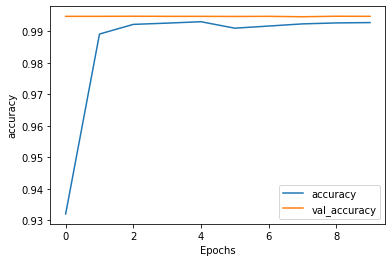

In [31]:
plot_graphs(history, 'accuracy')

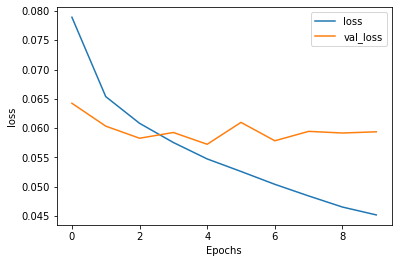

In [32]:
plot_graphs(history, 'loss')

### Combination of CNN and LSTM model

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

In [0]:
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

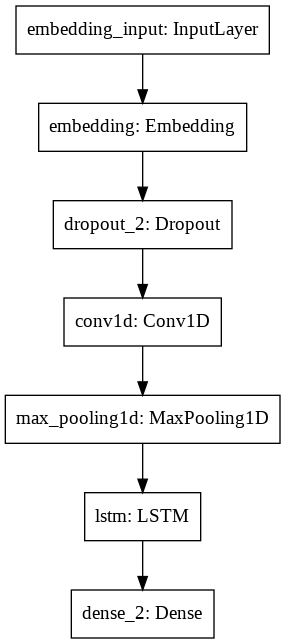

In [35]:
tf.keras.utils.plot_model(model)

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          32467000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 32,532,478
Trainable params: 65,478
Non-trainable params: 32,467,000
_______________________________________

In [37]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 20, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/20
3990/3990 [==============================] - 67s 17ms/step - loss: 0.0909 - accuracy: 0.9771 - val_loss: 0.0710 - val_accuracy: 0.9881
Epoch 2/20
3990/3990 [==============================] - 64s 16ms/step - loss: 0.0730 - accuracy: 0.9900 - val_loss: 0.0673 - val_accuracy: 0.9940
Epoch 3/20
3990/3990 [==============================] - 67s 17ms/step - loss: 0.0698 - accuracy: 0.9928 - val_loss: 0.0667 - val_accuracy: 0.9945
Epoch 4/20
3990/3990 [==============================] - 67s 17ms/step - loss: 0.0673 - accuracy: 0.9936 - val_loss: 0.0668 - val_accuracy: 0.9919
Epoch 5/20
3990/3990 [==============================] - 67s 17ms/step - loss: 0.0659 - accuracy: 0.9938 - val_loss: 0.0655 - val_accuracy: 0.9947
Epoch 6/20
3990/3990 [==============================] - 67s 17ms/step - loss: 0.0637 - accuracy: 0.9934 - val_loss: 0.0658 - val_accuracy: 0.9947
Epoch 7/20
3990/3990 [==============================] - 67s 17ms/step - loss: 0.0622 - accuracy: 0.9937 -

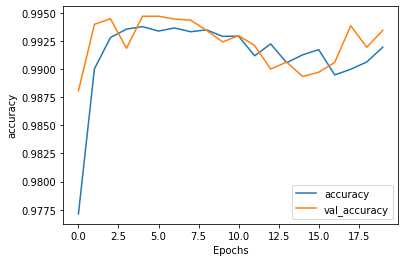

In [38]:
plot_graphs(history, 'accuracy')

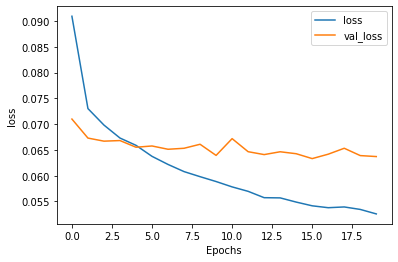

In [39]:
plot_graphs(history, 'loss')